8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Linear Regression RMSE: 0.3197357162114013
Neural Network RMSE: 0.8385530276223141
SVR RMSE: 3.831427873198906
Random Forest RMSE: 36.44940988358985
SARIMA RMSE: 19.371710653320044


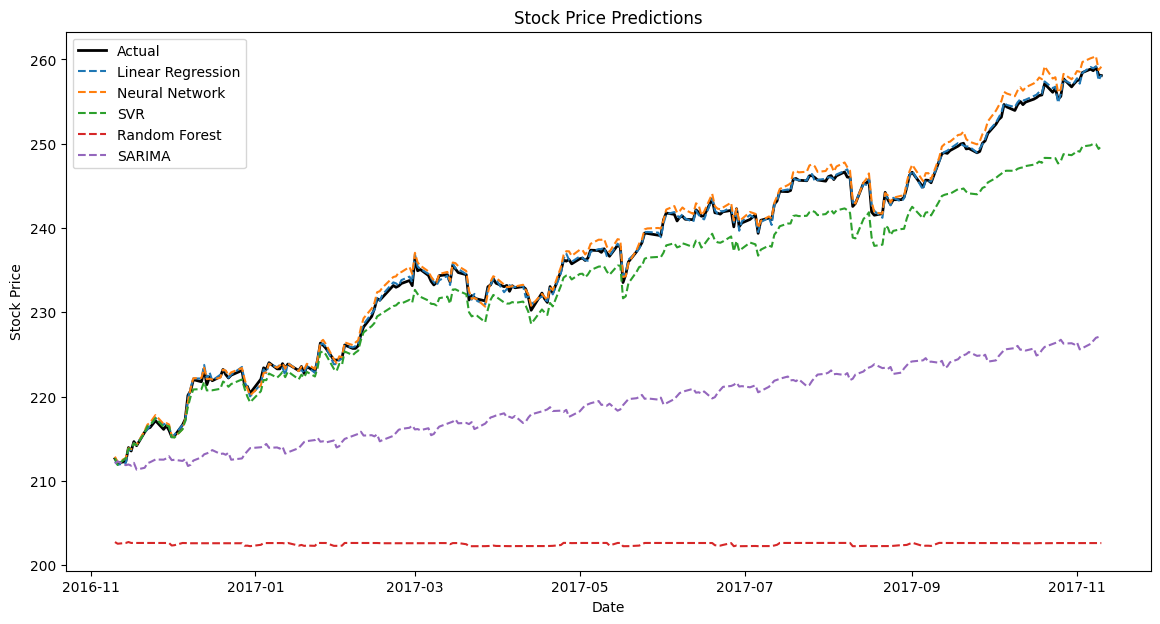

In [1]:
# standard uten

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator

# Load and preprocess the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])
df = df.sort_values('Date')

# Calculate lagged features and technical indicators
df['Close_Lag_5'] = df['Close'].shift(5)
df['Close_Lag_10'] = df['Close'].shift(10)
df['Close_Lag_20'] = df['Close'].shift(20)
df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
df['SMA_200'] = SMAIndicator(df['Close'], window=200).sma_indicator()
df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

features = ['Open', 'High', 'Low', 'Volume', 'Close_Lag_5', 'Close_Lag_10', 'Close_Lag_20',
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_Signal']
target = 'Close'

# Drop NaNs introduced by lag features and indicators
df.dropna(inplace=True)

# Set Date as index and ensure frequency
df.set_index('Date', inplace=True)
df = df.asfreq('B')  # Using business day frequency
df = df.dropna()  # Drop any remaining NaN values

# Define train, validation, and test sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
validation_start_date = end_date - pd.DateOffset(years=2)

train = df[df.index < validation_start_date].copy()
validation = df[(df.index >= validation_start_date) & (df.index < test_start_date)].copy()
test = df[df.index >= test_start_date].copy()

# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
validation_scaled = scaler.transform(validation[features])
test_scaled = scaler.transform(test[features])

# Feature selection (RFE with Linear Regression)
rfe = RFE(LinearRegression(), n_features_to_select=10)
train_rfe = rfe.fit_transform(train_scaled, train[target])
validation_rfe = rfe.transform(validation_scaled)
test_rfe = rfe.transform(test_scaled)

# Models setup
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(train_rfe, train[target])
predictions_lr = lr_model.predict(test_rfe)

# Neural Network
nn_model = Sequential([
    Input(shape=(train_rfe.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(train_rfe, train[target], epochs=100, batch_size=10, verbose=0)
predictions_nn = nn_model.predict(test_rfe).flatten()

# SVM with Grid Search
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'epsilon': [0.1, 0.2]}
svr = SVR(kernel='rbf')
svr_model = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_model.fit(validation_rfe, validation[target])
predictions_svr = svr_model.best_estimator_.predict(test_rfe)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=69)
rf_model.fit(train_rfe, train[target])
predictions_rf = rf_model.predict(test_rfe)

# Additive Model (SARIMA)
sarima_model = SARIMAX(validation[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Align SARIMA predictions with test dates using integer-based indices
# The integer-based approach ensures `start` and `end` match the SARIMA model's training period.
predictions_sarima = sarima_fit.predict(
    start=len(validation),  # Start prediction after the end of validation
    end=len(validation) + len(test) - 1,  # Predict for the test period length
)

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(test[target], predictions_lr)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(test[target], predictions_nn)))
print("SVR RMSE:", np.sqrt(mean_squared_error(test[target], predictions_svr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(test[target], predictions_rf)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test[target], predictions_sarima)))

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test[target], label='Actual', color='black', linewidth=2)
plt.plot(test.index, predictions_lr, label='Linear Regression', linestyle='--')
plt.plot(test.index, predictions_nn, label='Neural Network', linestyle='--')
plt.plot(test.index, predictions_svr, label='SVR', linestyle='--')
plt.plot(test.index, predictions_rf, label='Random Forest', linestyle='--')
plt.plot(test.index, predictions_sarima, label='SARIMA', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Linear Regression RMSE: 0.32538657857275183
Neural Network RMSE: 0.6202303901385932
SVR RMSE: 1.8221446291466423
Random Forest RMSE: 36.4830098297456
SARIMA RMSE: 19.371710653320044


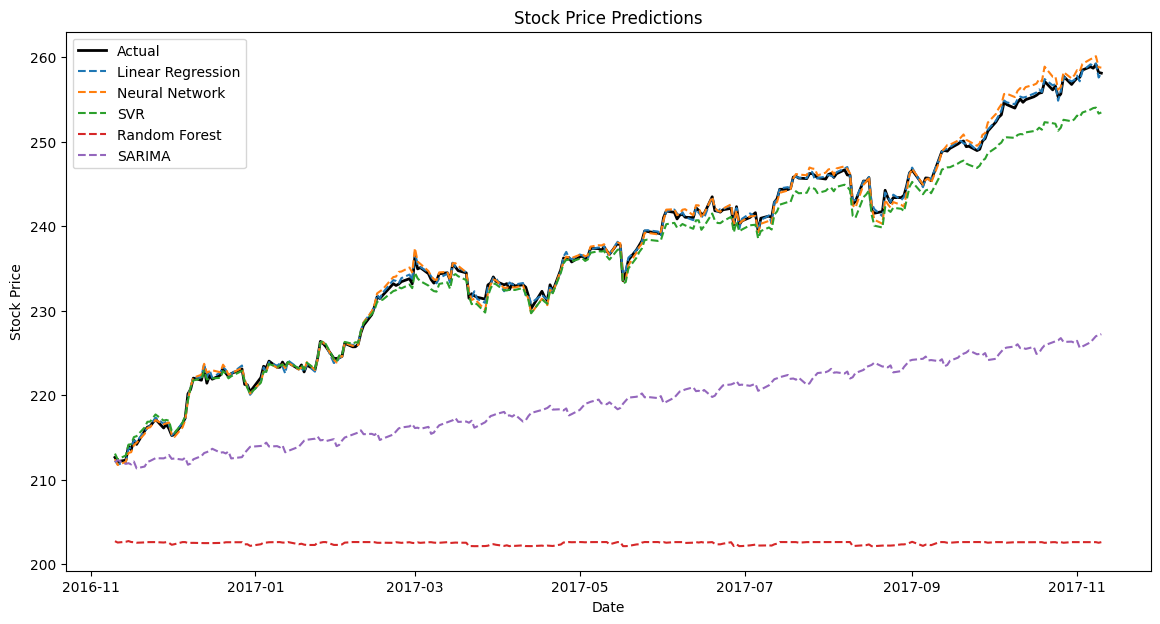

In [2]:
# eksperiemnt uten

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator

# Load and preprocess the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])
df = df.sort_values('Date')

# Calculate lagged features and technical indicators
df['Close_Lag_20'] = df['Close'].shift(20)
df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
df['SMA_200'] = SMAIndicator(df['Close'], window=200).sma_indicator()
df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

features = ['Open', 'High', 'Low', 'Volume', 'Close_Lag_20',
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_Signal']
target = 'Close'

# Drop NaNs introduced by lag features and indicators
df.dropna(inplace=True)

# Set Date as index and ensure frequency
df.set_index('Date', inplace=True)
df = df.asfreq('B')  # Using business day frequency
df = df.dropna()  # Drop any remaining NaN values

# Define train, validation, and test sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
validation_start_date = end_date - pd.DateOffset(years=2)

train = df[df.index < validation_start_date].copy()
validation = df[(df.index >= validation_start_date) & (df.index < test_start_date)].copy()
test = df[df.index >= test_start_date].copy()

# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
validation_scaled = scaler.transform(validation[features])
test_scaled = scaler.transform(test[features])

# Feature selection (RFE with Linear Regression)
rfe = RFE(LinearRegression(), n_features_to_select=10)
train_rfe = rfe.fit_transform(train_scaled, train[target])
validation_rfe = rfe.transform(validation_scaled)
test_rfe = rfe.transform(test_scaled)

# Models setup
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(train_rfe, train[target])
predictions_lr = lr_model.predict(test_rfe)

# Neural Network
nn_model = Sequential([
    Input(shape=(train_rfe.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(train_rfe, train[target], epochs=100, batch_size=10, verbose=0)
predictions_nn = nn_model.predict(test_rfe).flatten()

# SVM with Grid Search
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'epsilon': [0.1, 0.2]}
svr = SVR(kernel='rbf')
svr_model = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_model.fit(validation_rfe, validation[target])
predictions_svr = svr_model.best_estimator_.predict(test_rfe)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_rfe, train[target])
predictions_rf = rf_model.predict(test_rfe)

# Additive Model (SARIMA)
sarima_model = SARIMAX(validation[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Align SARIMA predictions with test dates using integer-based indices
# The integer-based approach ensures `start` and `end` match the SARIMA model's training period.
predictions_sarima = sarima_fit.predict(
    start=len(validation),  # Start prediction after the end of validation
    end=len(validation) + len(test) - 1,  # Predict for the test period length
)

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(test[target], predictions_lr)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(test[target], predictions_nn)))
print("SVR RMSE:", np.sqrt(mean_squared_error(test[target], predictions_svr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(test[target], predictions_rf)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test[target], predictions_sarima)))

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test[target], label='Actual', color='black', linewidth=2)
plt.plot(test.index, predictions_lr, label='Linear Regression', linestyle='--')
plt.plot(test.index, predictions_nn, label='Neural Network', linestyle='--')
plt.plot(test.index, predictions_svr, label='SVR', linestyle='--')
plt.plot(test.index, predictions_rf, label='Random Forest', linestyle='--')
plt.plot(test.index, predictions_sarima, label='SARIMA', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Number of components selected to retain % variance: 8


c:\IT3212\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Linear Regression RMSE: 0.6448475023817997
Neural Network RMSE: 2.9754516102351154
SVR RMSE: 10.821055407348062
Random Forest RMSE: 37.62246091286425
SARIMA RMSE: 19.371710653320044


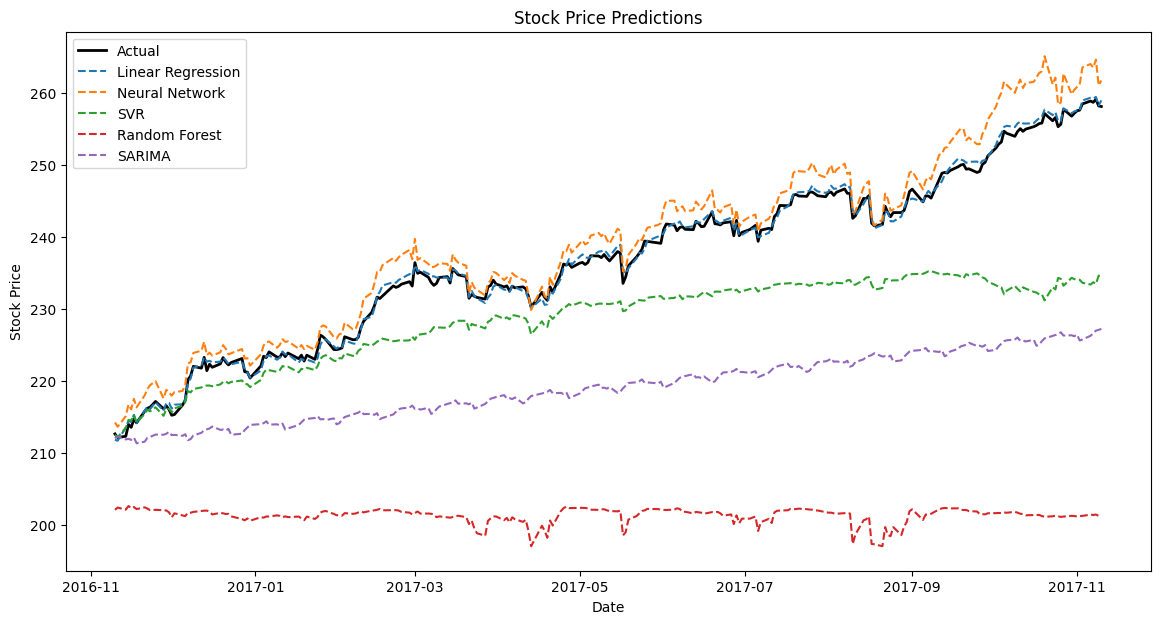

In [3]:
# standard med

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator

# Load and preprocess the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])
df = df.sort_values('Date')

# Create an empty list to store lagged columns
lagged_columns = []

# Define the lags you want to use
lags = [i for i in range(5, 20, 5)]

# Loop over each feature and create lagged versions
for feature in ['Open', 'High', 'Low', 'Volume', 'Close']:
    for lag in lags:
        lagged_columns.append(df[feature].shift(lag).rename(f'{feature}_Lag_{lag}'))

# Concatenate all lagged columns to the original DataFrame
df = pd.concat([df] + lagged_columns, axis=1)

# Calculate technical indicators
sma_50 = SMAIndicator(df['Close'], window=50).sma_indicator()
sma_200 = SMAIndicator(df['Close'], window=200).sma_indicator()
rsi = RSIIndicator(df['Close'], window=14).rsi()
macd = MACD(df['Close'])

# Concatenate technical indicators all at once
df = pd.concat([df, sma_50.rename('SMA_50'), sma_200.rename('SMA_200'), rsi.rename('RSI'), macd.macd().rename('MACD'), macd.macd_signal().rename('MACD_Signal')], axis=1)

# Define features (all the lagged features and technical indicators)
features = [f'{feature}_Lag_{lag}' for feature in ['Open', 'High', 'Low', 'Volume', 'Close'] for lag in lags]
features += ['SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_Signal']

# Define the target
target = 'Close'

# Drop NaNs introduced by lag features and indicators
df.dropna(inplace=True)

# Set Date as index and ensure frequency
df.set_index('Date', inplace=True)
df = df.asfreq('B')  # Using business day frequency
df = df.dropna()  # Drop any remaining NaN values

# Define train, validation, and test sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
validation_start_date = end_date - pd.DateOffset(years=2)

train = df[df.index < validation_start_date].copy()
validation = df[(df.index >= validation_start_date) & (df.index < test_start_date)].copy()
test = df[df.index >= test_start_date].copy()

# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
validation_scaled = scaler.transform(validation[features])
test_scaled = scaler.transform(test[features])

# Feature selection (PLS Regression to retain 95% variance)
pls = PLSRegression(n_components=min(train_scaled.shape[1], train_scaled.shape[0]))  # Set max possible components
pls.fit(train_scaled, train[target])

# Compute the singular values and explained variance
singular_values = pls.x_scores_  # PLS scores (components)
explained_variance = np.var(singular_values, axis=0)  # Variance along each component
total_variance = np.sum(explained_variance)  # Total variance

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance) / total_variance

# Find the number of components that explain at least % of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.99) + 1  # +1 because indexing starts at 0

# Fit PLS with the selected number of components
pls = PLSRegression(n_components=n_components_95)
train_pls = pls.fit_transform(train_scaled, train[target])[0]
validation_pls = pls.transform(validation_scaled)
test_pls = pls.transform(test_scaled)

print(f"Number of components selected to retain % variance: {n_components_95}")

# Apply Recursive Feature Elimination (RFE) to further reduce features from PLS components
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(rf_model, n_features_to_select=20)  # Select the top 20 features
train_pls_selected = selector.fit_transform(train_pls, train[target])
validation_pls_selected = selector.transform(validation_pls)
test_pls_selected = selector.transform(test_pls)

# Models setup
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(train_pls_selected, train[target])
predictions_lr = lr_model.predict(test_pls_selected)

# Neural Network
nn_model = Sequential([
    Input(shape=(train_pls_selected.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(train_pls_selected, train[target], epochs=100, batch_size=10, verbose=0)
predictions_nn = nn_model.predict(test_pls_selected).flatten()

# SVM with Grid Search
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'epsilon': [0.1, 0.2]}
svr = SVR(kernel='rbf')
svr_model = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_model.fit(validation_pls_selected, validation[target])
predictions_svr = svr_model.best_estimator_.predict(test_pls_selected)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_pls_selected, train[target])
predictions_rf = rf_model.predict(test_pls_selected)

# Additive Model (SARIMA)
sarima_model = SARIMAX(validation[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
predictions_sarima = sarima_fit.predict(start=len(validation), end=len(validation) + len(test) - 1)

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(test[target], predictions_lr)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(test[target], predictions_nn)))
print("SVR RMSE:", np.sqrt(mean_squared_error(test[target], predictions_svr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(test[target], predictions_rf)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test[target], predictions_sarima)))

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test[target], label='Actual', color='black', linewidth=2)
plt.plot(test.index, predictions_lr, label='Linear Regression', linestyle='--')
plt.plot(test.index, predictions_nn, label='Neural Network', linestyle='--')
plt.plot(test.index, predictions_svr, label='SVR', linestyle='--')
plt.plot(test.index, predictions_rf, label='Random Forest', linestyle='--')
plt.plot(test.index, predictions_sarima, label='SARIMA', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


c:\IT3212\.venv\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 30
  warnings.warn(f"y residual is constant at iteration {k}")
c:\IT3212\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=13. There will be no feature selection and all features will be kept.
  warnings.warn(


Number of components selected to retain 99% variance: 13
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\IT3212\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Linear Regression RMSE: 1.1850050664008398
Neural Network RMSE: 8.691341398239418
SVR RMSE: 34.63342413522011
Random Forest RMSE: 79.54155644283185
SARIMA RMSE: 40.266701321512514


ValueError: x and y must have same first dimension, but have shapes (253,) and (54,)

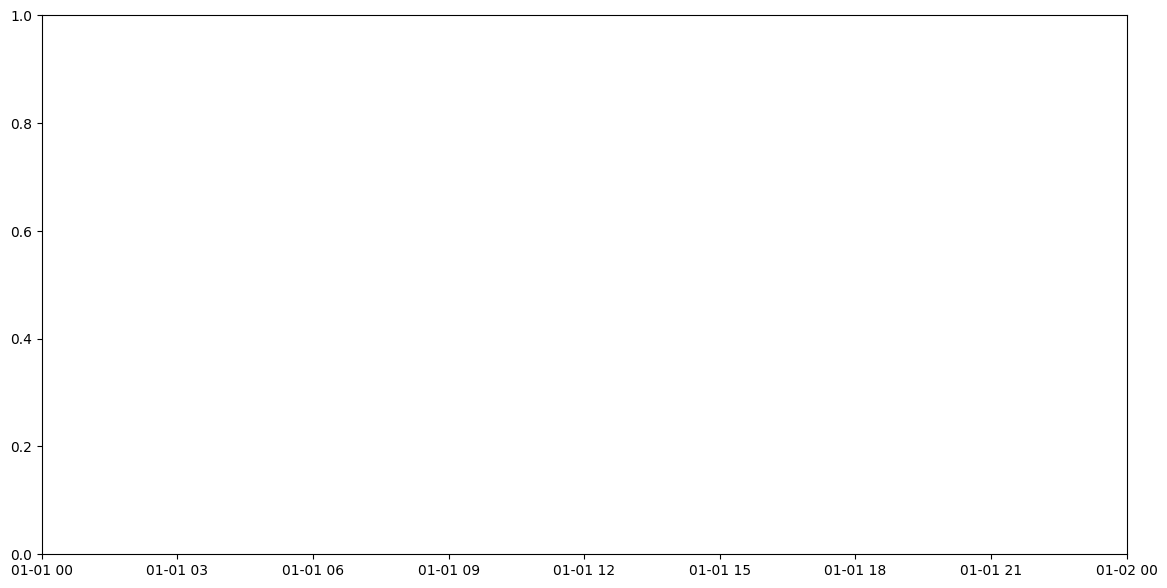

In [7]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from keras.models import Sequential
from keras.layers import Dense, Input
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

# Load the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])

# Sort by date
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Function to create features
def create_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week

    for lag in range(1, 8):  # Lagged features for 1 to 7 days
        df[f'lag_{lag}'] = df['Close'].shift(lag)

    df['rolling_mean_7'] = df['Close'].rolling(window=7).mean()
    df['rolling_std_7'] = df['Close'].rolling(window=7).std()
    df['ema_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['lag_diff_1'] = df['Close'].diff(1)

    # Technical Indicators
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['SMA_200'] = SMAIndicator(df['Close'], window=200).sma_indicator()
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    bollinger = BollingerBands(df['Close'])
    df['Bollinger_Middle'] = bollinger.bollinger_mavg()
    df['Bollinger_Upper'] = bollinger.bollinger_hband()
    df['Bollinger_Lower'] = bollinger.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()

    # Drop rows with NaN values caused by lagging and indicators
    df.dropna(inplace=True)
    return df

# Define the cutoff dates
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)

# Split the data
train = df[df.index < test_start_date].copy()
test = df[df.index >= test_start_date].copy()

# Prepare features
train_features = create_features(train.copy())
test_features = create_features(test.copy())

# Separate features and target variable for training set
X_train = train_features.drop(columns=['Close'])
y_train = train_features['Close']
X_test = test_features.drop(columns=['Close'])
y_test = test_features['Close']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PLS Regression for feature reduction
pls = PLSRegression(n_components=min(X_train_scaled.shape[1], X_train_scaled.shape[0]))
pls.fit(X_train_scaled, y_train)

# Calculate the number of components for 99% explained variance
singular_values = pls.x_scores_
explained_variance = np.var(singular_values, axis=0)
total_variance = np.sum(explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance) / total_variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.99) + 1

# Update PLS with the selected number of components
pls = PLSRegression(n_components=n_components_95)
X_train_pls = pls.fit_transform(X_train_scaled, y_train)[0]
X_test_pls = pls.transform(X_test_scaled)

print(f"Number of components selected to retain 99% variance: {n_components_95}")

# RFE for feature selection from PLS components
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(rf_model, n_features_to_select=20)
X_train_pls_selected = selector.fit_transform(X_train_pls, y_train)
X_test_pls_selected = selector.transform(X_test_pls)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_pls_selected, y_train)
predictions_lr = lr_model.predict(X_test_pls_selected)

# Neural Network
nn_model = Sequential([
    Input(shape=(X_train_pls_selected.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train_pls_selected, y_train, epochs=100, batch_size=10, verbose=0)
predictions_nn = nn_model.predict(X_test_pls_selected).flatten()

# SVM with predefined parameters
svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.2)
svr.fit(X_train_pls_selected, y_train)
predictions_svr = svr.predict(X_test_pls_selected)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True)
rf_model.fit(X_train_pls_selected, y_train)
predictions_rf = rf_model.predict(X_test_pls_selected)

# SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
predictions_sarima = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, predictions_lr)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(y_test, predictions_nn)))
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, predictions_svr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, predictions_rf)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(y_test, predictions_sarima)))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, predictions_lr, label='Linear Regression', linestyle='--')
plt.plot(test.index, predictions_nn, label='Neural Network', linestyle='--')
plt.plot(test.index, predictions_svr, label='SVR', linestyle='--')
plt.plot(test.index, predictions_rf, label='Random Forest', linestyle='--')
plt.plot(test.index, predictions_sarima, label='SARIMA', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Input
from statsmodels.tsa.seasonal import STL
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator, CCIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

# Function to create features
def create_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    for lag in range(1, 8):  # Lagged features for 1 to 7 days
        df[f'lag_{lag}'] = df['Close'].shift(lag)
        
    df['rolling_mean_7'] = df['Close'].rolling(window=7).mean()
    df['rolling_std_7'] = df['Close'].rolling(window=7).std()
    df['ema_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    
    df['lag_diff_1'] = df['Close'].diff(1)
    
    # Technical Indicators
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['SMA_200'] = SMAIndicator(df['Close'], window=200).sma_indicator()
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    bollinger = BollingerBands(df['Close'])
    df['Bollinger_Middle'] = bollinger.bollinger_mavg()
    df['Bollinger_Upper'] = bollinger.bollinger_hband()
    df['Bollinger_Lower'] = bollinger.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()
    
    # Drop rows with NaN values caused by lagging and indicators
    df.dropna(inplace=True)
    return df

# Load the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Feature Extraction
df = create_features(df)

# Define the cutoff dates
test_start_date = df.index.max() - pd.DateOffset(years=1)

# Split the data
train = df[df.index < test_start_date]
test = df[df.index >= test_start_date]

# Separate features and target variable
X_train = train.drop(columns=['Close'])
y_train = train['Close']
X_test = test.drop(columns=['Close'])
y_test = test['Close']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the datasets
print(f"Train Set Shape: {train.shape}")
print(f"Test Set Shape: {test.shape}")


Train Set Shape: (2749, 34)
Test Set Shape: (253, 34)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Linear Regression RMSE: 2.7216603535890062e-14
Neural Network RMSE: 0.31312303547688924
SVR RMSE: 19.97469472426982
Random Forest RMSE: 26.36519312288969
Additive Model RMSE: 1.627414307176098e-13


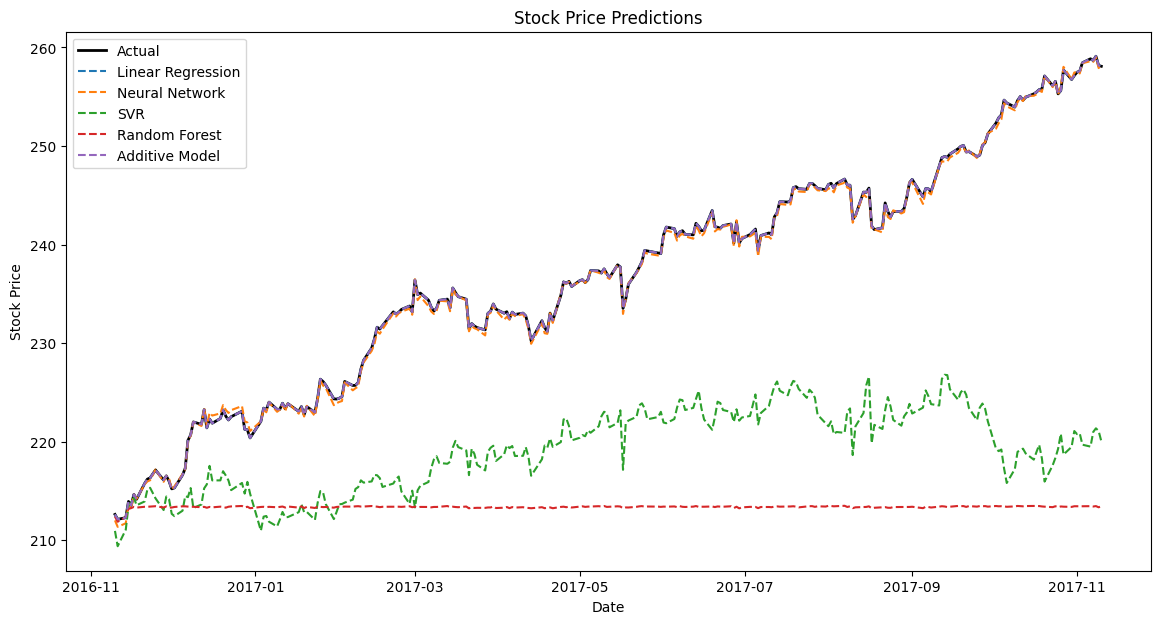

In [11]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Neural Network
nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
nn_predictions = nn_model.predict(X_test_scaled).flatten()

# SVM with predefined parameters
svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.2)
svr.fit(X_train_scaled, y_train)
svr_predictions = svr.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Additive Model
stl = STL(train['Close'], seasonal=13, period = 252)
res = stl.fit()
train_seasonal, train_trend = res.seasonal, res.trend

stl_test = STL(test['Close'], seasonal=13, period = 252)
res_test = stl_test.fit()
test_seasonal, test_trend = res_test.seasonal, res_test.trend

additive_predictions = test_trend + test_seasonal

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_predictions)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(y_test, nn_predictions)))
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, svr_predictions)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("Additive Model RMSE:", np.sqrt(mean_squared_error(y_test, additive_predictions)))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, lr_predictions, label='Linear Regression', linestyle='--')
plt.plot(test.index, nn_predictions, label='Neural Network', linestyle='--')
plt.plot(test.index, svr_predictions, label='SVR', linestyle='--')
plt.plot(test.index, rf_predictions, label='Random Forest', linestyle='--')
plt.plot(test.index, additive_predictions, label='Additive Model', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Neural Network
nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
nn_predictions = nn_model.predict(X_test_scaled).flatten()

# SVM with predefined parameters
# svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.2)
# svr.fit(X_train_scaled, y_train)
# svr_predictions = svr.predict(X_test_scaled)
# SVM with Grid Search
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'epsilon': [0.1, 0.2]}
svr = SVR(kernel='rbf')
svr_model = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_model.fit(X_train_scaled, y_train)
predictions_svr = svr_model.best_estimator_.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Additive Model
stl = STL(train['Close'], seasonal=13, period = 252)
res = stl.fit()
train_seasonal, train_trend = res.seasonal, res.trend

stl_test = STL(test['Close'], seasonal=13, period = 252)
res_test = stl_test.fit()
test_seasonal, test_trend = res_test.seasonal, res_test.trend

additive_predictions = test_trend + test_seasonal

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_predictions)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(y_test, nn_predictions)))
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, svr_predictions)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("Additive Model RMSE:", np.sqrt(mean_squared_error(y_test, additive_predictions)))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, lr_predictions, label='Linear Regression', linestyle='--')
plt.plot(test.index, nn_predictions, label='Neural Network', linestyle='--')
plt.plot(test.index, svr_predictions, label='SVR', linestyle='--')
plt.plot(test.index, rf_predictions, label='Random Forest', linestyle='--')
plt.plot(test.index, additive_predictions, label='Additive Model', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
